### Loading Libraries

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # read and wrangle dataframes
import matplotlib.pyplot as plt # visualization
import seaborn as sns # statistical visualizations and aesthetics
from sklearn.base import TransformerMixin # To create new classes for transformations
from sklearn.preprocessing import (FunctionTransformer, StandardScaler) # preprocessing 
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import boxcox # data transform
from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, 
                                     cross_val_score, GridSearchCV, 
                                     learning_curve, validation_curve) # model selection modules
from sklearn.pipeline import Pipeline # streaming pipelines
from sklearn.base import BaseEstimator, TransformerMixin # To create a box-cox transformation class
from collections import Counter
import warnings
# load models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import (XGBClassifier, plot_importance)
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from time import time

%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

### Dataset Exploration

In [2]:
df = pd.read_csv('../input/glass/glass.csv')
features = df.columns[:-1].tolist()
print(df.shape)

(214, 10)


In [3]:
df.head(15)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [4]:
df.dtypes

RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object

### Data Summarization

In [5]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [6]:
df['Type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

### Data Visualization

Univariate Plots

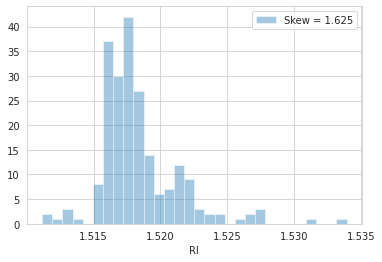

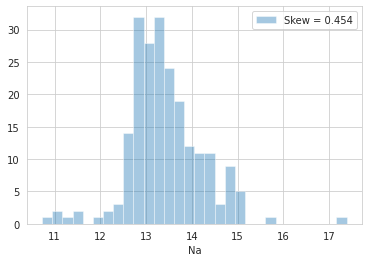

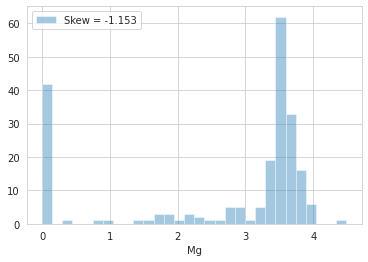

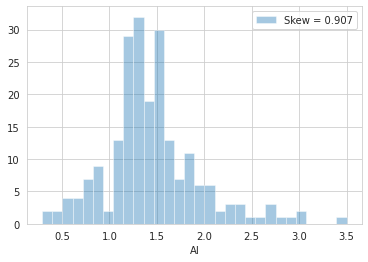

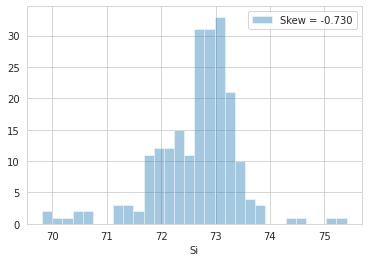

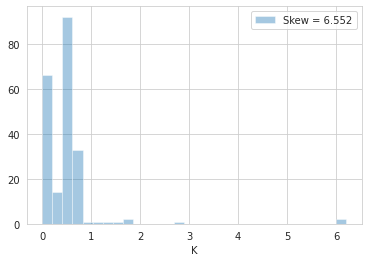

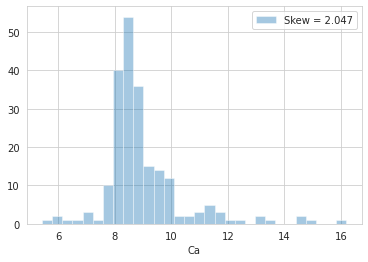

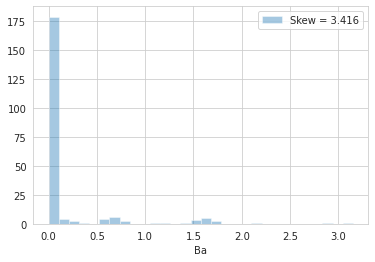

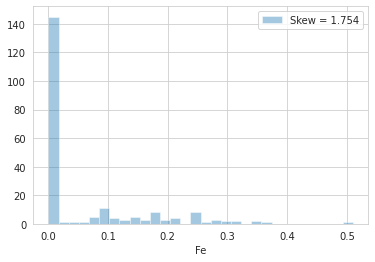

In [7]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

Detecting observations with multiple outliers

In [8]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[features])))) 

The dataset contains 14 observations with more than 2 outliers


Boxplot

<AxesSubplot:>

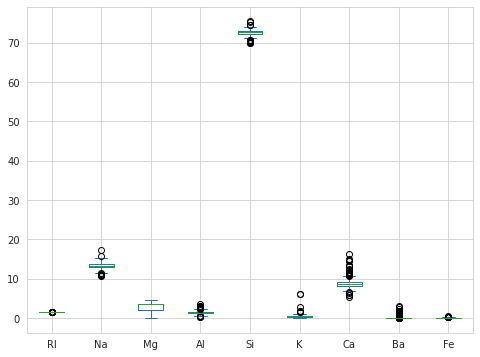

In [9]:
df[features].plot(figsize=(8,6), kind='box')

Pairplot

<Figure size 576x576 with 0 Axes>

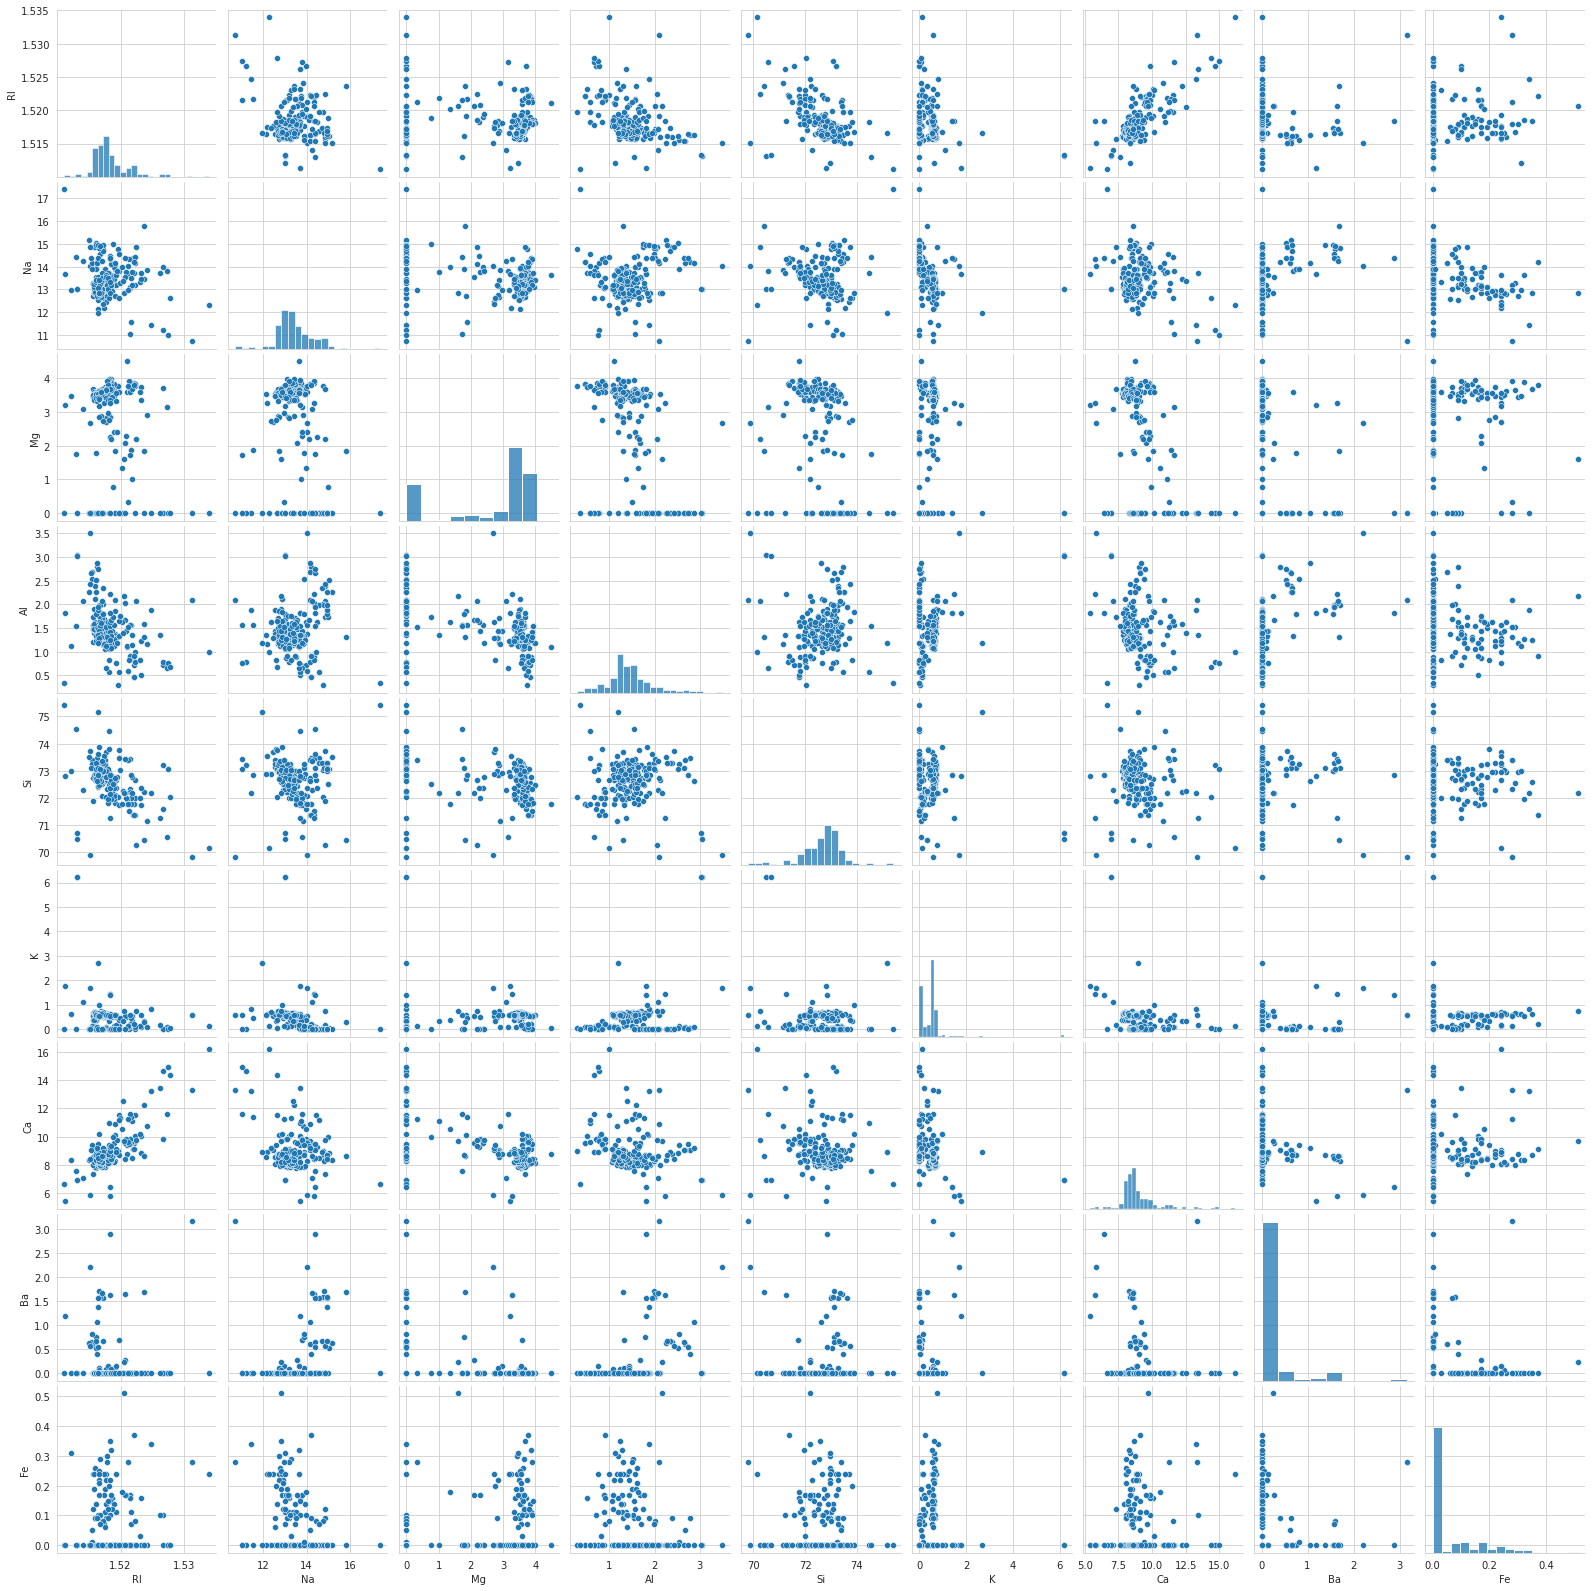

In [10]:
plt.figure(figsize=(8,8))
sns.pairplot(df[features],palette='coolwarm')
plt.show()


Heatmap

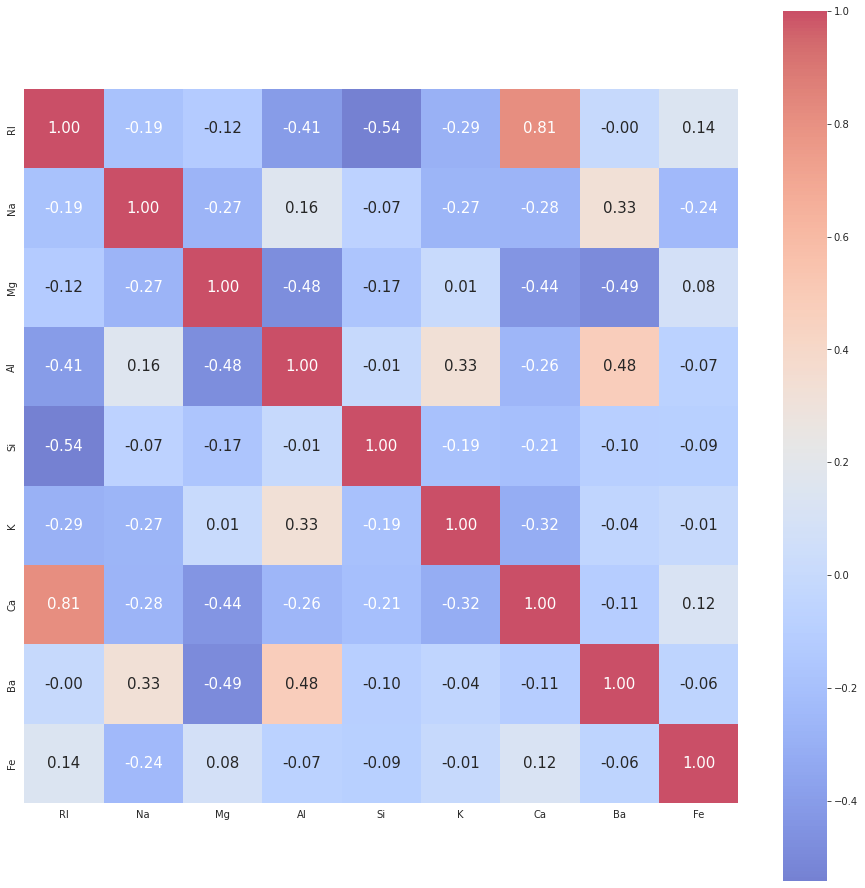

In [11]:
corr = df[features].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

### Data Preparation

Data Cleaning

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


Removing Multiple outliers

In [13]:
outlier_indices = outlier_hunt(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)

(200, 10)


Plot after removing of observations with multiple outliers

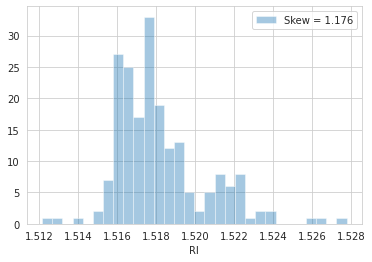

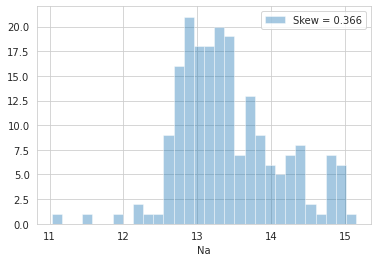

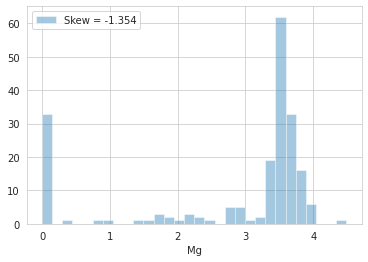

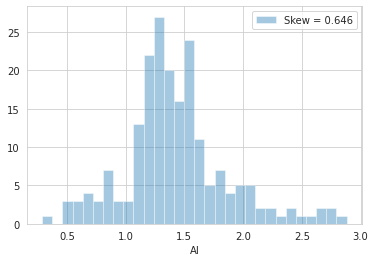

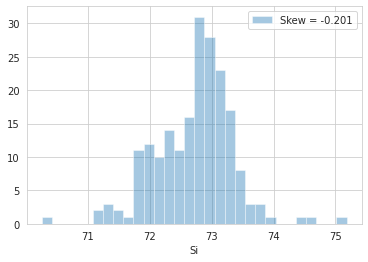

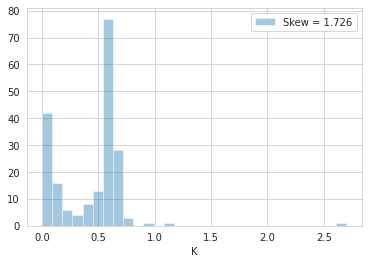

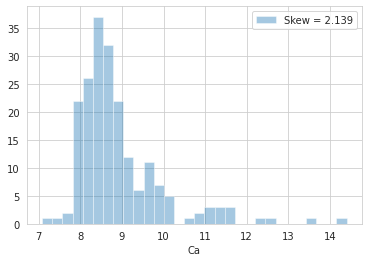

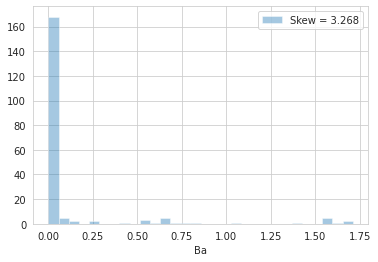

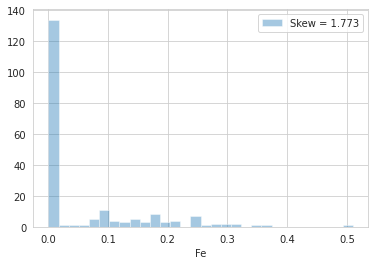

In [14]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde=False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [15]:
df['Type'].value_counts()

1    70
2    70
7    25
3    17
5    10
6     8
Name: Type, dtype: int64

### Plotting distribution of types

Countplot

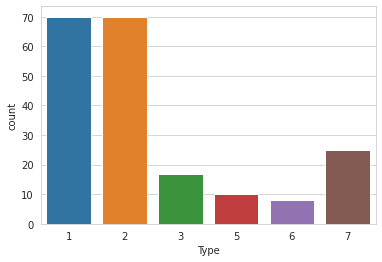

In [16]:
sns.countplot(df['Type'])
plt.show()

### Splitting validation dataset

In [17]:
# Define X as features and y as lablels
X = df[features] 
y = df['Type'] 
# set a seed and a test size for splitting the dataset 
seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size , random_state = seed)

### Data Transformation

In [18]:
features_boxcox = []

for feature in features:
    bc_transformed, _ = boxcox(df[feature]+1)  # shift by 1 to avoid computing log of negative values
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
df_bc = pd.DataFrame(data=features_boxcox, columns=features)
df_bc['Type'] = df['Type']

In [19]:
df_bc.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,200.000000,200.000000,200.000000,200.000000,2.000000e+02,200.000000,2.000000e+02,200.000000,200.000000,200.000000
mean,0.000616,0.910643,14.813501,0.955244,6.067071e+09,0.342872,1.999249e-01,0.013377,0.019141,2.670000
std,0.000000,0.003076,8.011923,0.217702,2.873472e+08,0.213507,8.577972e-07,0.031188,0.027757,2.054802
min,0.000616,0.897962,0.000000,0.261374,5.004587e+09,0.000000,1.999215e-01,0.000000,0.000000,1.000000
25%,0.000616,0.908540,10.569803,0.850076,5.893126e+09,0.122922,1.999244e-01,0.000000,0.000000,1.000000
50%,0.000616,0.910269,18.555034,0.938477,6.106954e+09,0.447403,1.999248e-01,0.000000,0.000000,2.000000
75%,0.000616,0.912445,19.835863,1.060851,6.238759e+09,0.480536,1.999254e-01,0.000000,0.051652,3.000000
max,0.000616,0.917711,31.408319,1.561947,7.293074e+09,1.392148,1.999270e-01,0.091142,0.068796,7.000000


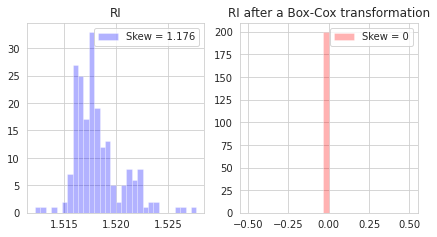

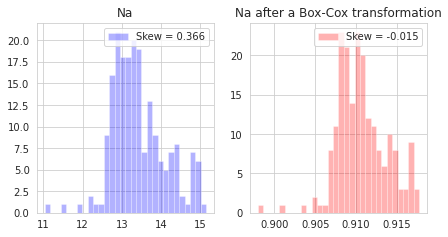

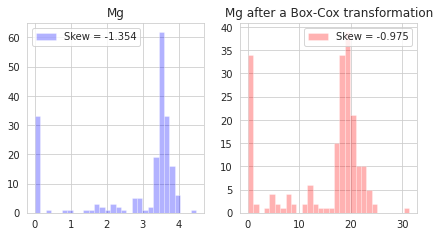

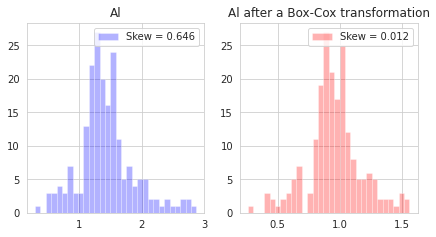

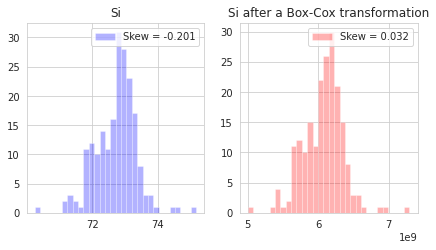

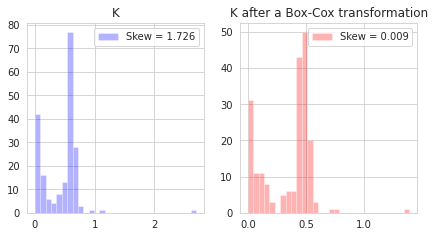

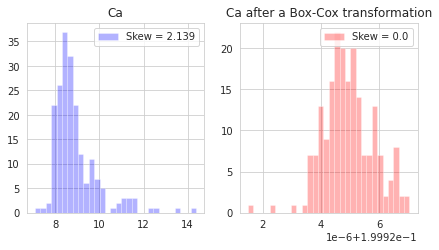

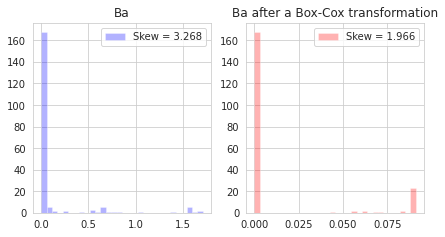

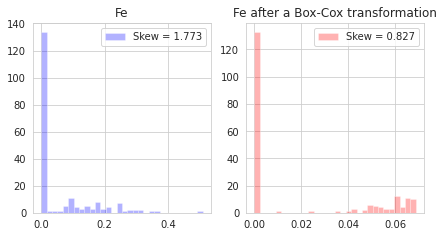

In [20]:
for feature in features:
    fig, ax = plt.subplots(1,2,figsize=(7,3.5))    
    ax[0].hist(df[feature], color='blue', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df[feature].skew(),3))) )
    ax[0].set_title(str(feature))   
    ax[0].legend(loc=0)
    ax[1].hist(df_bc[feature], color='red', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df_bc[feature].skew(),3))) )
    ax[1].set_title(str(feature)+' after a Box-Cox transformation')
    ax[1].legend(loc=0)
    plt.show()

In [21]:
# check if skew is closer to zero after a box-cox transform
for feature in features:
    delta = np.abs( df_bc[feature].skew() / df[feature].skew() )
    if delta < 1.0 :
        print('Feature %s is less skewed after a Box-Cox transform' %(feature))
    else:
        print('Feature %s is more skewed after a Box-Cox transform'  %(feature))

Feature RI is less skewed after a Box-Cox transform
Feature Na is less skewed after a Box-Cox transform
Feature Mg is less skewed after a Box-Cox transform
Feature Al is less skewed after a Box-Cox transform
Feature Si is less skewed after a Box-Cox transform
Feature K is less skewed after a Box-Cox transform
Feature Ca is less skewed after a Box-Cox transform
Feature Ba is less skewed after a Box-Cox transform
Feature Fe is less skewed after a Box-Cox transform


## Algorithm Evaluation

### Dimensionality Reduction

PCA

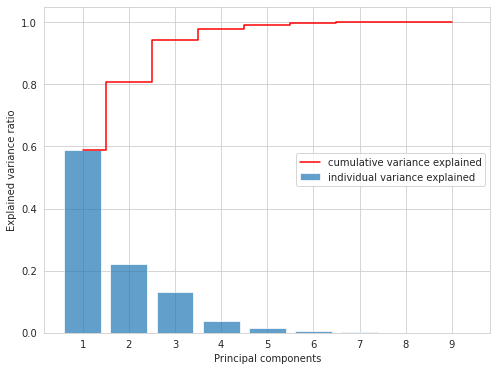

In [22]:
pca = PCA(random_state = seed)
pca.fit(X_train)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
plt.figure(figsize=(8,6))
plt.bar(range(1,len(cum_var_exp)+1), var_exp, align= 'center', label= 'individual variance explained', \
       alpha = 0.7)
plt.step(range(1,len(cum_var_exp)+1), cum_var_exp, where = 'mid' , label= 'cumulative variance explained', \
        color= 'red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(np.arange(1,len(var_exp)+1,1))
plt.legend(loc='center right')
plt.show()
